<a href="https://colab.research.google.com/github/malraharsh/temp2/blob/master/Training_Blood_NoBlood_(Colab).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import argparse
import os
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from imutils import paths
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import (
    AveragePooling2D, Dense, Dropout, Flatten, Input, MaxPooling2D)
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import (ImageDataGenerator,
                                                  img_to_array, load_img)
from tensorflow.keras.utils import to_categorical

from PIL import Image

In [ ]:
import zipfile
zip = zipfile.ZipFile('/content/drive/My Drive/Others/Blood_noblood.zip','r')
zip.extractall('/content/')
zip.close()

In [11]:
data_dir = 'Blood_noblood'
blood_dir = os.path.join(data_dir, 'blood')
noblood_dir = os.path.join(data_dir, 'noblood')

In [36]:
def getFiles(path):
    return ([os.path.join(path, p) for p in os.listdir(path)])

def getCorrupted(df):
    corrupted = []
    for impath in df.files:
        try:
            plt.imread(impath)
        except:
            corrupted.append(impath)
    return corrupted
            
def removeCorrupted(df, corrupted):
    todrop = df[[f in corrupted for f in df['files']]].index
    print("Removed {}".format(len(corrupted)))
    return df.drop(todrop)


In [39]:
df_blood = pd.DataFrame({'files': getFiles(blood_dir), 'labels': '1'})
df_noblood = pd.DataFrame({'files': getFiles(noblood_dir), 'labels': '0'})

corrupted_blood = getCorrupted(df_blood)
corrupted_noblood = getCorrupted(df_noblood)

df_blood = removeCorrupted(df_blood, corrupted_blood)
df_noblood = removeCorrupted(df_noblood, corrupted_noblood)

Removed 0
Removed 1


In [40]:
df = pd.concat([df_blood, df_noblood])
df.reset_index(drop=True, inplace=True)
df.head()

,files,labels
0,Blood_noblood/blood/blood_181.jpg,1
1,Blood_noblood/blood/blood_182.jpg,1
2,Blood_noblood/blood/blood_27.jpg,1
3,Blood_noblood/blood/blood_377.jpg,1
4,Blood_noblood/blood/blood_110.jpg,1


In [35]:
# sample = df.loc[0][0]
# Image.open(sample)

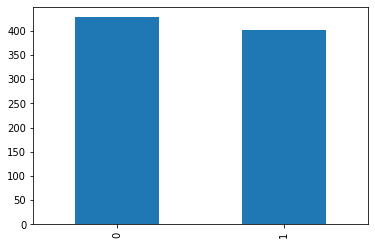

In [41]:
df['labels'].value_counts().plot.bar()

Found 663 validated image filenames belonging to 2 classes.
Found 166 validated image filenames belonging to 2 classes.


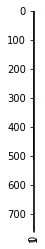

In [42]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_CHANNELS=3
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_SHAPE=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)

train_df, val_df = train_test_split(df, test_size=0.20, random_state=123)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

size_train = train_df.shape[0]
size_val = val_df.shape[0]
BATCH_SIZE = 25

train_datagen = ImageDataGenerator(
    rotation_range=20,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.25,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='files',
    y_col='labels',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    val_df, 
    x_col='files',
    y_col='labels',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)


In [ ]:
def show(df):
    plt.figure(figsize=(12, 12))
    for i in range(0, 9):
        plt.subplot(3, 3, i+1)
        image = plt.imread(df.loc[random.choice(df.index)][0])
        plt.imshow(image)
    plt.tight_layout()
    plt.show()

# show(df_noblood)

# show(df_blood)


In [43]:
base = MobileNetV2(input_tensor=Input(shape=(128,128, 3)), weights="imagenet", include_top=False)

In [44]:
model = Sequential()
model.add(base)
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(2, activation="softmax"))

base.trainable = False
          
optimizer = Adam(lr=1e-4)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 1280)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               163968    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 2,422,210
Trainable params: 164,226
Non-trainable params: 2,257,984
______________________________________

In [49]:
EPOCHS = 30
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = EPOCHS,
            validation_steps=1,
            verbose=2)


Epoch 1/30
27/27 - 16s - loss: 0.2165 - accuracy: 0.9201 - val_loss: 0.1815 - val_accuracy: 0.9200
Epoch 2/30
27/27 - 15s - loss: 0.1758 - accuracy: 0.9351 - val_loss: 0.4711 - val_accuracy: 0.8800
Epoch 3/30
27/27 - 15s - loss: 0.2284 - accuracy: 0.9140 - val_loss: 0.2907 - val_accuracy: 0.8400
Epoch 4/30
27/27 - 15s - loss: 0.2106 - accuracy: 0.9095 - val_loss: 0.2738 - val_accuracy: 0.8800
Epoch 5/30
27/27 - 15s - loss: 0.1960 - accuracy: 0.9231 - val_loss: 0.3125 - val_accuracy: 0.8400
Epoch 6/30
27/27 - 14s - loss: 0.2026 - accuracy: 0.9110 - val_loss: 0.1616 - val_accuracy: 0.9200
Epoch 7/30
27/27 - 15s - loss: 0.1626 - accuracy: 0.9291 - val_loss: 0.2307 - val_accuracy: 0.9200
Epoch 8/30
27/27 - 15s - loss: 0.1982 - accuracy: 0.9110 - val_loss: 0.4886 - val_accuracy: 0.7600
Epoch 9/30
27/27 - 15s - loss: 0.1675 - accuracy: 0.9336 - val_loss: 0.2484 - val_accuracy: 0.8800
Epoch 10/30
27/27 - 15s - loss: 0.1732 - accuracy: 0.9291 - val_loss: 0.2032 - val_accuracy: 0.8400
Epoch 11/

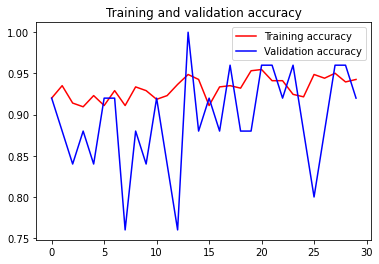

<Figure size 432x288 with 0 Axes>

In [50]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [51]:
model.save('Mobile-epochs-40.h5')